## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [1]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm

import seaborn as sns
import matplotlib.pyplot as plt

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

%matplotlib inline

nlp = en_core_web_sm.load()

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [2]:
# Opening JSON file 
file_path = open('../input/automatic-ticket-classification/complaints-2021-05-14_08_16.json') # Write the path to your data file and load it 
  
# returns JSON object as  
# a dictionary 
data = json.load(file_path)
df = pd.json_normalize(data)

## Data preparation

In [3]:
# Inspect the dataframe to understand the given data.
pd.set_option('max_columns', None)
df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,_source.consumer_disputed,_source.product,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [5]:
# Print the column names
def print_column_names():
    i = 1
    for col in df.columns:
        print(str("{:02d}".format(i)) +" Column:\033[1m", col, '\033[0m')
        i += 1
        
print_column_names()

01 Column: _index 
02 Column: _type 
03 Column: _id 
04 Column: _score 
05 Column: _source.tags 
06 Column: _source.zip_code 
07 Column: _source.complaint_id 
08 Column: _source.issue 
09 Column: _source.date_received 
10 Column: _source.state 
11 Column: _source.consumer_disputed 
12 Column: _source.product 
13 Column: _source.company_response 
14 Column: _source.company 
15 Column: _source.submitted_via 
16 Column: _source.date_sent_to_company 
17 Column: _source.company_public_response 
18 Column: _source.sub_product 
19 Column: _source.timely 
20 Column: _source.complaint_what_happened 
21 Column: _source.sub_issue 
22 Column: _source.consumer_consent_provided 


In [6]:
# Assign new column names
new_columns = {}
for col in df.columns:
    new_columns[col] = re.sub("^_", "", col).replace("source.", "")

df.rename(columns = new_columns, inplace = True)

print_column_names()

01 Column: index 
02 Column: type 
03 Column: id 
04 Column: score 
05 Column: tags 
06 Column: zip_code 
07 Column: complaint_id 
08 Column: issue 
09 Column: date_received 
10 Column: state 
11 Column: consumer_disputed 
12 Column: product 
13 Column: company_response 
14 Column: company 
15 Column: submitted_via 
16 Column: date_sent_to_company 
17 Column: company_public_response 
18 Column: sub_product 
19 Column: timely 
20 Column: complaint_what_happened 
21 Column: sub_issue 
22 Column: consumer_consent_provided 


In [7]:
# Get the shape and size of the dataset
print('No of rows:\033[1m', df.shape[0], '\033[0m')
print('No of cols:\033[1m', df.shape[1], '\033[0m')

No of rows: 78313 
No of cols: 22 


In [8]:
# Assign nan in place of blanks in the complaints column
df.complaint_what_happened.replace(r'', np.nan, regex=True, inplace=True)

In [9]:
# Remove all rows where complaints column is nan
df = df[df.complaint_what_happened.notna()]
print('Remaining Rows:\033[1m', len(df), '\033[0m')

Remaining Rows: 21072 


## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Use POS tags to get relevant words from the texts.


In [10]:
# Write your function here to clean the text and remove all the unnecessary elements.
def cleaned_text(sentence):
    sentence = sentence.lower()
    sentence = re.sub("[\[].*?[\]]", "", sentence)
    sentence = re.sub(r'[^\w\s]','', sentence) 
    sentence = re.sub(r'[0-9]', '', sentence, re.I|re.A)
    return sentence

In [11]:
# Write your function to Lemmatize the texts
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet, stopwords
from nltk.corpus import stopwords

stop = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# function to convert nltk tag to wordnet tag
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

def lemmatized_text(sentence):
    # tokenize into words
    words = nltk.word_tokenize(sentence)
    
    # remove stop words (this is optional but generally done)
    words = [word for word in words if word not in stopwords.words("english")]
    
    # tokenize the sentence and find the POS tag for each token
    nltk_tagged = nltk.pos_tag(words)
    
    # tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            # if there is no available tag, append the token as is
            lemmatized_sentence.append(word)
        else:        
            # else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)

In [12]:
from tqdm import tqdm

# Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df_clean = pd.DataFrame()

for x in tqdm(df.complaint_what_happened):
    df_clean = df_clean.append({'raw_complaints':x, 'lemmatized_complaints':lemmatized_text(cleaned_text(x))}, ignore_index=True)

100%|██████████| 21072/21072 [17:00<00:00, 20.65it/s]


In [13]:
df_clean

,raw_complaints,lemmatized_complaints
0,Good morning my name is XXXX XXXX and I apprec...,good morning name xxxx xxxx appreciate could h...
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,upgraded xxxx xxxx card xxxx tell agent upgrad...
2,Chase Card was reported on XX/XX/2019. However...,chase card report xxxx however fraudulent appl...
3,"On XX/XX/2018, while trying to book a XXXX XX...",xxxx try book xxxx xxxx ticket come across off...
4,my grand son give me check for {$1600.00} i de...,grand son give check deposit chase account fun...
...,...,...
21067,After being a Chase Card customer for well ove...,chase card customer well decade offer multiple...
21068,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",wednesday xxxxxxxx call chas xxxx xxxx visa cr...
21069,I am not familiar with XXXX pay and did not un...,familiar xxxx pay understand great risk provid...
21070,I have had flawless credit for 30 yrs. I've ha...,flawless credit yrs ive chase credit card chas...


In [14]:
from textblob import TextBlob

tqdm.pandas()

# Write your function to extract the POS tags 
def extract_pos_tag(sentence):
    # Create a textblob object
    blob = TextBlob(sentence)
    
    # extract words with tags 'NN', join them and return
    return ' '.join([ word for (word,tag) in blob.tags if tag == "NN"])
    
df_clean["complaint_POS_removed"] = df_clean.progress_apply(lambda x: extract_pos_tag(x.lemmatized_complaints), axis=1)
df_clean["length"] = df_clean.progress_apply(lambda x: len(x.complaint_POS_removed), axis=1)

100%|██████████| 21072/21072 [00:00<00:00, 47522.49it/s]


In [15]:
# The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean

,raw_complaints,lemmatized_complaints,complaint_POS_removed,length
0,Good morning my name is XXXX XXXX and I apprec...,good morning name xxxx xxxx appreciate could h...,morning name appreciate chase bank cardmember ...,175
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,upgraded xxxx xxxx card xxxx tell agent upgrad...,xxxx card tell agent date information order up...,117
2,Chase Card was reported on XX/XX/2019. However...,chase card report xxxx however fraudulent appl...,card report application submit identity consen...,81
3,"On XX/XX/2018, while trying to book a XXXX XX...",xxxx try book xxxx xxxx ticket come across off...,try book ticket come offer apply ticket card i...,429
4,my grand son give me check for {$1600.00} i de...,grand son give check deposit chase account fun...,son check deposit chase account fund bank acco...,163
...,...,...,...,...
21067,After being a Chase Card customer for well ove...,chase card customer well decade offer multiple...,chase card customer decade offer solicitation ...,232
21068,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",wednesday xxxxxxxx call chas xxxx xxxx visa cr...,call chas xxxx credit card provider claim purc...,702
21069,I am not familiar with XXXX pay and did not un...,familiar xxxx pay understand great risk provid...,pay risk consumer chase bank chase year trust ...,695
21070,I have had flawless credit for 30 yrs. I've ha...,flawless credit yrs ive chase credit card chas...,flawless credit chase credit card chase freedo...,563


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length.
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text.
*   Find the top unigrams, bigrams and trigrams by frequency among all the complaints after processing the text.

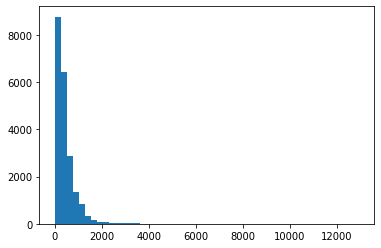

In [16]:
# Write your code here to visualise the data according to the 'Complaint' character length
%matplotlib inline

import matplotlib.pyplot as plt

plt.hist(df_clean.length, bins=50)
plt.show()

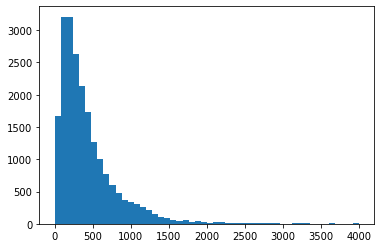

In [17]:
plt.hist([l for l in df_clean.length if l < 4000], bins=50)
plt.show()

#### Find the top 40 words by frequency among all the articles after processing the text.

In [18]:
# Using a word cloud find the top 40 words by frequency among all the articles after processing the text


In [19]:
# Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [20]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 


In [21]:
#Print the top 10 words in the unigram frequency


In [22]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 


In [23]:
#Print the top 10 words in the bigram frequency

In [24]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 


In [25]:
#Print the top 10 words in the trigram frequency

## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [26]:
#df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [27]:
#All masked texts has been removed
#df_clean

## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [28]:
#Write your code here to initialise the TfidfVectorizer 



#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [29]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.


## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [30]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [31]:
#Load your nmf_model with the n_components i.e 5
#num_topics = #write the value you want to test out

#keep the random_state =40
#nmf_model = #write your code here

In [32]:
#nmf_model.fit(dtm)
#len(tfidf.get_feature_names())

In [33]:
#Print the Top15 words for each of the topics


In [34]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4



In [35]:
#Assign the best topic to each of the cmplaints in Topic Column

#df_clean['Topic'] = #write your code to assign topics to each rows.

In [36]:
#df_clean.head()

In [37]:
#Print the first 5 Complaint for each of the Topics
#df_clean=df_clean.groupby('Topic').head(5)
#df_clean.sort_values('Topic')

#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [38]:
#Create the dictionary of Topic names and Topics

#Topic_names = {   }
#Replace Topics with Topic Names
#df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [39]:
#df_clean

## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [40]:
#Create the dictionary again of Topic names and Topics

#Topic_names = {   }
#Replace Topics with Topic Names
#df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [41]:
#df_clean

In [42]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
#training_data=

In [43]:
#training_data

#### Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [44]:

#Write your code to get the Vector count


#Write your code here to transform the word vector to tf-idf

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [45]:
# Write your code here to build any 3 models and evaluate them using the required metrics



